In [1]:
import pynbody
import matplotlib.pylab as plt
import numpy as np
import pandas as pd
%matplotlib inline
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [2]:
#galaxy_masses=pd.DataFrame()
#BH_halos=pd.DataFrame()
snap_id=0

In [718]:
def loader(path):
    '''returns snapshot and halo'''
    snap=pynbody.load(path)
    snap.physical_units()
    h=snap.halos()
    return snap,h

def BH_finder(snap):
    '''returns subsnap of black holes'''
    return snap.star[pynbody.filt.BandPass('tform','-15 Gyr','0 Gyr')]

def analysis(halo, view=0):
    '''center snap on halo's center of mass (angmom gives errors if there aren't enough pixels). 
    view=1 for face on, 2 for side on, anything else will leave it as is'''
    if view==1:
        pynbody.analysis.angmom.faceon(halo)
    elif view==2:
        pynbody.analysis.angmom.sideon(halo)
    else:
        pynbody.analysis.halo.center(halo)
        
def plot_BH_pos(h, BH, attribute, cmap='Greys', w=100, lc='best',save=False, filename='plots/dg_adjTime/h%s_t%s_w%s.png'):
    '''plots position of black holes. Send halo array(h[grpid]), black hole array(BH),attribute 
    Optional: width/preferred scope(w) (default=100), colormap(default='Greys'), save(default=False)'''
    
    halo_id=int(np.unique(h['amiga.grp']))
    time=h.properties['time'].in_units('Gyr')
    
    pynbody.plot.image(h,qty=attribute,cmap=cmap, width=w, log=False)
    
    for i in np.where(BH['amiga.grp']==halo_id):
        plt.annotate('local max', xy=(2, 1), xytext=(3, 1.5))
    plt.xlim(-w/2,w/2)
    plt.ylim(-w/2,w/2)
    plt.title('Halo %s at %s Gyr'%(halo_id, round(time, 2)))
    plt.legend(fancybox=True, loc='lc')
    plt.tight_layout()

    if save==True:
        plt.savefig(filename%(halo_id, round(time, 2), w),bbox_inches='tight', dpi=200)

        

def adjust_csv_index(df):
    df=df.rename(columns={'Unnamed: 0':'snap'})
    df=df.set_index('snap')
    
def add_mass_columns(hgrpid, grpid, snap_id):
    '''returns row with gas, stellar, and total masses for one halo tracked through time'''
    df=pd.DataFrame([[hgrpid.g['mass'].sum(), hgrpid.s['mass'].sum(), hgrpid['mass'].sum()]], index=[snap_id], columns=['H[%d] Gas'%(grpid),'H[%d] Star'%(grpid),'H[%d] Total'%(grpid)])
    df.units='Msol'
    return df
    
def mass_df(h, BHgrp, snap_id):
    df=pd.DataFrame()
    for i in BHgrp:
        df=pd.concat([df, add_mass_columns(h[i], i, snap_id)], axis=1, join='outer')
    df.units='Msol'
    return df
    
def galaxy_df(snap_id,h,BHgrp):
    '''snap_id_array[snap_id], h, np.unique(BH['amiga.grp'])'''
    galaxy_masses=pd.DataFrame()
    for i in snap_id:
        vars()['mass_%s'%(i)]=mass_df(h,BHgrp,i)
        galaxy_masses=galaxy_masses.append(vars()['mass_%s'%(i)])
    return galaxy_masses
    if save==True:
        galaxy_masses.to_csv('csvdata/%s_galaxy_masses.csv'%(snap_id))        
    
def plot_SFH(h, grpid, snap_id, c='k', save=True, mf=False, filename='plots/SFH/i_%s_SFH.png'): #%s_h[%s]_SFH.png'):
    '''plots SFH. Send halo array(h[grpid]), color(c=k) grpid, and snapshot you want to plot 
    Optional:save(default=True)
    #examples of iterative SFH:
    for i in np.unique(BH['amiga.grp']): #using black hole array
        plot_SFH(h,i,snap_id_array[snap_id], mf=False)
    for i in np.unique(iords[str(snap_id_array[snap_id])+' halo groups'].dropna()): #using iords array
        plot_SFH(h,i,snap_id_array[snap_id], mf=False)'''
    plt.clf()
    pynbody.plot.sfh(h[grpid].s,color=c, massform=mf);
    plt.title('%s_h[%s]_SFH'%(snap_id,grpid), y=1.14);
    if save==True:
        plt.savefig(filename,bbox_inches='tight', dpi=200);
        
def SFH(simstars, filename=None, massform=False, subplot=False, trange=False, bins=100, **kwargs):
    if subplot:
        plt=subplot
    trange=[simstars['tform'].in_units("Gyr").min(), simstars['tform'].in_units("Gyr").max()]
    binnorm=1e-9*bins/(trange[1]-trange[0])
    trangefilt=pynbody.filt.And(pynbody.filt.HighPass('tform', str(trange[0]) + ' Gyr'), pynbody.filt.LowPass('tform', str(trange[1]) + ' Gyr'))
    tforms=simstars[trangefilt]['tform'].in_units('Gyr')
    weight=simstars[trangefilt]['mass'].in_units('Msol')*binnorm

    sfhist, thebins, patches = plt.hist(tforms, weights=weight, bins=bins, histtype='step', **kwargs)
    
    if not subplot:
        plt.xlabel('Time [Gyr]', fontsize='large')
        plt.ylabel('SFR [M$_\odot$ yr$^{-1}$]', fontsize='large')
    else:
        plt.set_ylim(1.2 * np.min(sfhist), 1.2 * np.max(sfhist))
        
    return pynbody.array.SimArray(sfhist, "Msol yr**-1"), pynbody.array.SimArray(thebins, "Gyr")

def ihist(iord_df, wt,subplot=False, bins=100, **kwargs):
    if subplot:
        plt=subplot
    trange=[iord_df['time'].min(), iord_df['time'].max()]
    binnorm=1e-9*bins/(trange[1]-trange[0])
    weight=iord_df[wt]*binnorm

    hist,thebins,patches=plt.hist(iord_df['time'], weights=weight, bins=bins, histtype='step', **kwargs)
    
    if not subplot:
        plt.xlabel('Time [Gyr]', fontsize='large')
        plt.ylabel('whstfffffff', fontsize='large')
    else:
        plt.set_ylim(1.2 * np.min(hist), 1.2 * np.max(hist))
        
    return pynbody.array.SimArray(hist), pynbody.array.SimArray(thebins, "Gyr")

def BH_halo_add(snap_id, BH, BH_halos):
    '''snap_id_array[snap_id], BH, BH_halos'''
    df=pd.DataFrame({'%s halo groups'%(snap_id):BH['amiga.grp'],'%s iords'%(snap_id):BH['iord']})
    BH_halos=pd.concat([BH_halos, df], axis=1, join='outer')
    return BH_halos

def load_snap_csvs(snap_id):
    '''snap_id_array[snap_id]. load mass and iord csvs'''
    #masses=pd.DataFrame()
    masses=pd.read_csv('csvdata/galaxy_masses.csv',index_col='snap')
    iords=pd.DataFrame()
    iords=pd.read_csv('csvdata/iords.csv',index_col='snap')
    return masses,iords
    
def get_iords_df(iords, iords_list, masses, save=False):
    for i in iords_list:
        ind=0
        vars()['iord_%s'%(i)]=pd.DataFrame(columns=['gas', 'star', 'total'])
        iords_temp=iords[i].dropna()
        vars()['iord_%s'%(i)]['halo']=iords[i]
        for j in iords_temp.index:
            if pd.notnull(iords.at[j,i]):
                temp=[masses.at[j,'H[%s] Gas'%(int(iords.at[j,i]))],masses.at[j,'H[%s] Star'%(int(iords.at[j,i]))],masses.at[j,'H[%s] Total'%(int(iords.at[j,i]))]]
            if (pd.notnull(temp)).any():
                vars()['iord_%s'%(i)].loc[int(iords_temp.index[ind]),['gas','star','total']]=temp
            else: continue
            ind=ind+1
            vars()['iord_%s'%(i)]=vars()['iord_%s'%(i)].fillna(0)
            if save==True:
                vars()['iord_%s'%(i)].to_csv('csvdata/iord_%s.csv'%(i))
                
def iord_mass_plot(iord_df, iord_id, save=False, filename='plots/galaxy_masses/iord_%s_masses.png'):
    plt.hist(range(0,len(iord_df)), weights=iord_df['total'], bins=len(iord_df),width=.85, alpha=.3, histtype='bar', label='Total', color='#666666',rwidth=1, align='mid')
    plt.hist([range(0,len(iord_df)),range(0,len(iord_df))], weights=[iord_df['gas'],iord_df['star']],bins=len(iord_df),width=.85, alpha=1, histtype='bar', stacked=True, label=['Gas','Stars'],fill=True, color=['#44AA99','#88CCEE'],rwidth=1,align='mid')
    plt.title('Masses of Halo Containing iord %s'%(iord_id));
    plt.ylabel('Mass [M$_\odot$]', fontsize='large');
    plt.legend(fancybox=True,loc='best')
    plt.yscale('log')
    if save==True:
        plt.savefig(filename%(iord_id),bbox_inches='tight')

def iord_gmass_plot(iord_df, time, bins=150, lc='best', htype= 'bar', halo_label=False, save=False, filename='plots/galaxy_masses/iord_%s_masses.png'):
    '''send individual iord dataframe, iord_id, timearray(time['time[Gyr]'])'''
    plt.clf()
    iord_id=iord_df.name
    
    #plt.hist(time['time[Gyr]'], weights=iord_df['total'], bins=bins, histtype=htype, label='Total', color='k', fill=True, linewidth=.2, alpha=.7);
    #plt.hist([time['time[Gyr]'], time['time[Gyr]']], weights=[iord_df['star'], iord_df['gas']], bins=bins, histtype=htype, label=['Stars', 'Gas'], color=['#FFEE33','#1B7837'],  stacked=True, fill=True);
    #plt.hist(time['time[Gyr]'], weights=iord_df['BH'], bins=bins, histtype=htype, label='BH', color='#662506', fill=False, linestyle='--');
    #plt.hist(time['time[Gyr]'], weights=iord_df['total'], bins=bins, histtype=htype, label='Total', color='k', fill=False, linestyle='--');
    plt.plot(time['time[Gyr]'], iord_df['total'], color='k', label='Total', linewidth=1.5)
    plt.plot(time['time[Gyr]'], iord_df['gas'], color='#1B7837', linestyle='--', label='Gas', linewidth=.8)
    plt.plot(time['time[Gyr]'], iord_df['star'], color='#FFEE33', linestyle='--', label='Stars', linewidth=.8)
    plt.plot(time['time[Gyr]'], iord_df['BH'], color='#662506', linestyle='--', label='BH', linewidth=.8)
    plt.title('Masses of Halo Containing iord %s'%(iord_id), y=1.14);
    plt.ylabel('Mass [M$_\odot$]', fontsize='large');
    plt.xlabel('Time [Gyr]', fontsize='large');
    plt.xlim(-.25,14)
    plt.legend(fancybox=True,loc=lc)
    plt.yscale('log')

    x0, x1 = plt.gca().get_xlim()
    old_axis = plt.gca()
    pz = plt.twiny()
    labelz=time_axis['z'][-6:]
    times=time_axis['time[Gyr]'][-6:]
    pz.set_xticks(times)
    pz.set_xticklabels([str(x) for x in labelz])
    pz.set_xlim(x0,x1)
    pz.set_xlabel('$z$')
    plt.sca(old_axis)

    if halo_label==True:
        prev=0
        for t in times:
            #if iord_df['halo'].str.contains('[').any():
                #iord_df['halo'] = iord_df['halo'].map(lambda x: str(x).lstrip('[').rstrip(']'))
            halo=iord_df[iord_df['age']==a]['halo'].item()
            if halo!=prev and halo!=0:
                plt.text(a, iord_df[iord_df['age']==a]['total'].values*1.1,str('%s'%(int(halo))), color='#666666')
                prev=halo
            else:continue

    plt.tight_layout()
    plt.subplots_adjust(top=1)
    if save==True:
        plt.savefig(filename%(iord_id),bbox_inches='tight', dpi=200)
        
def iord_r_plot(iord_df, time, bins=150, lc='best', htype= 'bar', halo_label=False, save=False, filename='plots/galaxy_masses/iord_%s_masses.png'):
    '''send individual iord dataframe, iord_id, timearray(time['time[Gyr]'])'''
    plt.clf()
    iord_id=iord_df.name
    
    plt.plot(time['time[Gyr]'], iord_df['r[kpc]'], color='k', linewidth=.9)
    #plt.hist(iord_df['time'], weights=iord_df['r'], bins=bins, histtype='step', color='k', linewidth=.9);
    plt.title('BH %s Radial Distance'%(iord_id), y=1.14);
    plt.ylabel('R [kpc]', fontsize='large'); 
    plt.xlabel('Time [Gyr]', fontsize='large');
    plt.xlim(-.25,14)
    #plt.yscale('log')

    x0, x1 = plt.gca().get_xlim()
    old_axis = plt.gca()
    pz = plt.twiny()
    labelz=time_axis['z'][-6:]
    times=time_axis['time[Gyr]'][-6:]
    pz.set_xticks(times)
    pz.set_xticklabels([str(x) for x in labelz])
    pz.set_xlim(x0,x1)
    pz.set_xlabel('$z$')
    plt.sca(old_axis)

    plt.tight_layout()
    plt.subplots_adjust(top=1)
    if save==True:
        plt.savefig(filename%(iord_id),bbox_inches='tight', dpi=200)
        
        
def iord_bhacc_plot(iord_df, time, bins=300, save=False, filename='plots/accretion_rates/iord_%s_accRates.png'):
    '''send individual iord dataframe, time array'''
    plt.clf()
    iord_id=iord_df.loc[0,'iord']
    
    plt.plot(iord_df['time'], iord_df['accRate'], color='k', linewidth=.9);
    plt.title('BH %s Accretion Rates'%(iord_id), y=1.14);
    plt.ylabel('Accretion Rate [M$_\odot$ yr$^{-1}$]]', fontsize='large');
    plt.xlabel('Time [Gyr]', fontsize='large');
    plt.xlim(-.25,14)
    plt.yscale('log')

    x0, x1 = plt.gca().get_xlim()
    old_axis = plt.gca()
    pz = plt.twiny()
    labelz=time_axis['z'][-6:]
    times=time_axis['time[Gyr]'][-6:]
    pz.set_xticks(times)
    pz.set_xticklabels([str(x) for x in labelz])
    pz.set_xlim(x0,x1)
    pz.set_xlabel('$z$')
    plt.sca(old_axis)

    plt.tight_layout()
    plt.subplots_adjust(top=1)
    if save==True:
        plt.savefig(filename%(iord_id),bbox_inches='tight', dpi=200)

def iord_bhmass_plot(iord_df, time, bins=300, save=False, filename='plots/distance/iord_%s_distance.png'):
    '''send individual iord dataframe, time array'''
    plt.clf()
    iord_id=iord_df.loc[0,'iord']
    
    plt.hist(iord_df['time'], weights=iord_df['mass'], bins=bins, histtype='step', color='k', linewidth=.9);
    plt.title('BH %s Mass'%(iord_id), y=1.14);
    plt.ylabel('Mass [M$_\odot$]', fontsize='large');
    plt.xlabel('Time [Gyr]', fontsize='large');
    plt.xlim(-.25,14)
    #plt.yscale('log')

    x0, x1 = plt.gca().get_xlim()
    old_axis = plt.gca()
    pz = plt.twiny()
    labelz=time_axis['z'][-6:]
    times=time_axis['time[Gyr]'][-6:]
    pz.set_xticks(times)
    pz.set_xticklabels([str(x) for x in labelz])
    pz.set_xlim(x0,x1)
    pz.set_xlabel('$z$')
    plt.sca(old_axis)

    plt.tight_layout()
    plt.subplots_adjust(top=1)
    if save==True:
        plt.savefig(filename%(iord_id), bbox_inches='tight', dpi=200)
        
def iord_bhr_plot(iord_df, time, bins=300, save=False, filename='plots/distance/iord_%s_distance.png'):
    '''send individual iord dataframe, time array'''
    plt.clf()
    iord_id=iord_df.loc[0,'iord']
    
    plt.hist(iord_df['time'], weights=iord_df['r'], bins=bins, histtype='step', color='k', linewidth=.9);
    plt.title('BH %s Radial Distance'%(iord_id), y=1.14);
    plt.ylabel('R [kpc]', fontsize='large');
    plt.xlabel('Time [Gyr]', fontsize='large');
    plt.xlim(-.25,14)
    plt.yscale('log')

    x0, x1 = plt.gca().get_xlim()
    old_axis = plt.gca()
    pz = plt.twiny()
    labelz=time_axis['z'][-6:]
    times=time_axis['time[Gyr]'][-6:]
    pz.set_xticks(times)
    pz.set_xticklabels([str(x) for x in labelz])
    pz.set_xlim(x0,x1)
    pz.set_xlabel('$z$')
    plt.sca(old_axis)

    plt.tight_layout()
    plt.subplots_adjust(top=1)
    if save==True:
        plt.savefig(filename%(iord_id),bbox_inches='tight', dpi=200)
        
def cycle_snap_id_array(snap_id_array,iords_list):
    '''loads each snap in snap_id_array and stores values to existing dataframes and saves as csvs(not as variable, so reload csv). Send snap_id_array, time dataframe, iords_list.
    Currently set to retrieve time[Gyr], z, BH[r], BH[mass]
    WARNING: This is going to be like a half hour wait or so
    Note: can send partial arrays'''
    time=pd.DataFrame(index=snap_id_array, columns=['time[Gyr]', 'z'])
    for j in snap_id_array:
        path='/data/scratch/jillian/h148/h148.cosmo50PLK.3072g3HbwK1BH.00%s/h148.cosmo50PLK.3072g3HbwK1BH.00%s'%(j,j)
        snap,h=loader(path)
        time.loc[j]['time[Gyr]']=snap.properties['time'].in_units('Gyr')
        time.loc[j]['z']=snap.properties['z']
        time.to_csv('csvdata/time.csv')
        BH=BH_finder(snap)
        for i in iords_list:
            temp=BH[np.where(BH['iord']==int(i))]['mass']
            if len(temp)>0:
                vars()['iord_%s'%(i)].loc[int(j),'BH']=temp
                vars()['iord_%s'%(i)].loc[int(j),'r[kpc]']=BH[np.where(BH['iord']==int(i))]['r']#change to getr
            vars()['iord_%s'%(i)].to_csv('csvdata/iord_%s.csv'%(i), index=False)
            
    #for j in snap_id_array:
    #    path='/data/scratch/jillian/h148/h148.cosmo50PLK.3072g3HbwK1BH.00%s/h148.cosmo50PLK.3072g3HbwK1BH.00%s'%(j,j)
    #    snap,h=loader(path)
    #    BH=BH_finder(snap)
    #    BH_arm=BH[pynbody.filt.BandPass('amiga.grp',2,200)]
    #    for i in BH_arm['iord']:
    #        ind=np.where(BH_arm['iord']==i)
    #        halo_id=BH_arm[ind]['amiga.grp']
    #        pynbody.analysis.halo.center(h[halo_id],mode='com')
    #        temp=np.sqrt((BH_arm[ind]['pos']**2).sum(axis=1))
    #        vars()['i_%s_data'%(i)].loc[int(snap_id_array[snap_id]),'r[kpc]']=temp
    #        pynbody.new('subsnaps/h%s_s%s'%(halo_id,j))

def get_orbits(iords_list, save=False):
    '''read .orbit file and convert to dataframe. long run time!'''
    cols=['iord', 'time', 'stepNumber', 'mass','xPos', 'yPos', 'zPos','xVel','yVel','zVel','pot','accRate','delM','FB_E_released','dt','scalefactor']
    orbit_file=pd.read_csv('/data/scratch/jillian/h148/h148.cosmo50PLK.3072g3HbwK1BH.orbit', header=None, sep=' ', index_col=False,names=cols)
    matches=np.isin(np.array(orbit_file['iord']), np.array(iords_list))
    bhorbit=orbit_file[matches]
    if save==True:
        bhorbit.to_csv('csvdata/bhorbit.csv', index=False)
    return bhorbit

def get_iorbits(iords_arm_list, save=True, filename='csvdata/i%s_orbit.csv'):
    '''return orbit dataframe for specified iord. long run time!'''
    bhorbit=get_orbits(iords_arm_list)
    for i in iords_arm_list:
        iord_id=int(i)
        mask=np.isin(np.array(bhorbit['iord']), i)
        i_orbit=bhorbit[mask]
        #mask2=np.isin(temp['stepNumber'], map(int, snap_id_array))
        i_orbit.loc[:,'accRate']=(i_orbit['accRate']*1.84793e16)/38759428183.8 #M_sol/yr
        i_orbit.loc[:,'time']=(i_orbit['time']*38759428183.8)/10**9 #Gyr
        i_orbit.loc[:,'mass']=i_orbit['mass']*1.84793e16 #M_sol
        i_orbit.loc[:,'xPos']=i_orbit['xPos']*50000 #kpc
        i_orbit.loc[:,'yPos']=i_orbit['yPos']*50000 #kpc
        i_orbit.loc[:,'zPos']=i_orbit['zPos']*50000 #kpc
        i_orbit=i_orbit.sort_values('time')
        if save==True:
            i_orbit.to_csv(filename%(iord_id), index=False)
        return i_orbit

def getr(BH):
    #vars()['i%s_orbit'%(i)]=vars()['i%s_orbit'%(i)].drop('Unnamed: 0.1', axis=1)
    return np.sqrt((BH['pos']**2).sum(axis=1))

def plot_all(iord_data, iord_df, time, save=False, filename='plots/dwarf_plots/h148_h%s.png'):
    tbins=np.linspace(iord_df['time'].min(),iord_df['time'].max(),500)
    tgroups=iord_df.groupby(np.digitize(iord_df.time, tbins))
    t=tgroups.mean()
    
    f,(ax1, ax2, ax3, ax4, ax5)=plt.subplots(5, sharex=True, dpi=100)
    ax1.plot(time['time[Gyr]'], iord_data['total'], label='Total Mass [M$_\odot$]', linewidth=.9, color='k')
    ax1.plot(time['time[Gyr]'], iord_data['gas'], linestyle='--', label='Gas Mass [M$_\odot$]', linewidth=.8, color='#1B7837')
    ax1.plot(time['time[Gyr]'], iord_data['star'], linestyle='--', label='Star Mass [M$_\odot$]', linewidth=.9, color='#FFEE33')
    ax1.plot(time['time[Gyr]'], iord_data['BH'], linestyle='--', label='BH Mass', linewidth=.8, color='#662506')
    ax2.plot(iord_df['time'], iord_df['mass'], linewidth=.8, linestyle='--', label='BH Mass [M$_\odot$]', color='#662506');
    ax3.plot(time['time[Gyr]'], iord_data['r[kpc]'], label='BH Radial Distance [kpc]', color='#88CCEE');
    ax4.plot(t['time'], t['accRate'], linewidth=.6, color='#6059A9', label='BH Accretion Rate [M$_\odot$ yr$^{-1}$]')
    sfhist,thebins=SFH(h_4096[halo_id].s, massform=False, subplot=ax5, color='#44AA99', label='SFR [M$_\odot$ yr$^{-1}$]')

    ax1.set_title('Properties of Halo %s ($z$=0) Throughout Time'%(halo_id), y=1.4,weight='bold')
    plt.setp([a.get_xticklabels() for a in f.axes[:-2]], visible=False)
    #plt.setp([a.get_yticklabels() for a in f.axes], visible=False)

    plt.xlim(0,14)


    x0, x1 = ax1.get_xlim()
    old_axis = plt.gca()
    pz = ax1.twiny()
    labelz=time_axis['z'][-6:]
    times=time_axis['time[Gyr]'][-6:]
    pz.set_xticks(times)
    pz.set_xticklabels([str(x) for x in labelz])
    pz.set_xlim(x0,x1)
    pz.set_xlabel('$z$')
    plt.sca(old_axis)


    y1label=ylabels(ax1)
    ax1.set_yticks(y1label)
    ax1.set_yticklabels([str(int(l)) for l in y1label], fontsize='xx-small')
    ax1.set_yscale('log')
    ax1.set_ylabel('Mass [M$_\odot$]', fontsize='x-small');
    #ax1.legend(fancybox=True, loc='upper left', bbox_to_anchor=(1, 1), ncol=1, fontsize='xx-small', frameon=False)

    y2label=ylabels(ax2)
    ax2.set_yticks(y2label)
    ax2.set_yticklabels([("{:.2e}".format(l)) for l in y2label], fontsize='xx-small')
    ax2.set_ylabel('BH Mass\n[M$_\odot$]', fontsize='x-small');
    #ax2.ticklabel_format(useOffset=False,style='plain')

    y3label=ylabels(ax3)
    ax3.set_yticks(y3label)
    ax3.set_yticklabels([str(round(l,1)) for l in y3label], fontsize='xx-small')
    ax3.set_ylabel('R [kpc]', fontsize='x-small'); 

    y4label=ylabels(ax4)
    ax4.set_yticks(y4label)
    ax4.set_yticklabels([str(l) for l in y4label], fontsize='xx-small')
    ax4.set_yscale('log')
    ax4.get_xaxis().get_major_formatter().labelOnlyBase = False
    ax4.set_ylabel('Accretion Rate\n[M$_\odot$ yr$^{-1}$]', fontsize='x-small');

    y5label=ylabels(ax5)
    ax5.set_yticks(y5label)
    ax5.set_yticklabels([str(l) for l in y5label], fontsize='xx-small')
    ax5.set_ylabel('SFR [M$_\odot$ yr$^{-1}$]', fontsize='x-small')
    ax5.set_xlabel('Time [Gyr]', fontsize='large');

    f.subplots_adjust(hspace=0)
    plt.subplots_adjust(top=1.5)
    
    if save==True:
        plt.savefig(filename%(halo_id),bbox_inches='tight', dpi=200)
        
def bin_down(iord_df,n):
    '''
    bins down iord_df to a shorter df defined by a bin width, x0(first point of new df), 
    and n(number of total points desired)
    '''
    step=(max(iord_df['time'])-min(iord_df['time']))/n
    x0=min(iord_df['time'])
    time_temp=[]
    binned_x0=0
    start=x0
    print step, time_temp
    for i in range(n):
        binned_x0=step+start
        start=binned_x0
        time_step=x0+(i*step)
        np.append(time_temp,time_step)
        
    accR=iord_df[np.isin(iord_df['time'],time_temp)]['accRate']
    
    return time_temp,accR

def ylabels(ax, log=False):
    
    if log==True:
        y0,y1=ax1.get_yticks().min(), ax1.get_yticks().max()
        span=y1-y0
        #span=round(span,-len(str(int(span)))+1)
        maxtick=y0
        mintick=y0
        midtick=y0
        for y in range(len(str(int(y0))),int(len(str(int(y1)))*.8)-2):
            maxtick=maxtick*10
        for y in range(len(str(int(y0))),int(len(str(int(y1)))*.5)-1):
            midtick=midtick*10
        for y in range(len(str(int(y0))),int(len(str(int(y1)))*.2)+2):
            mintick=maxtick*10
    else:
        y0,y1=ax.get_ylim()
    #maxy=int(np.ceil(y1))
    #miny=int(np.floor(y0))
        span=y1-y0
    
        if span<10:
            maxtick=round(y1*.8,2)
            mintick=round(y1*.5,2)
            midtick=round(y1*.2,2)
        else:
            #maxtick=int(round(y1*.8,int(-len(str(span))+len(str(span))*.6)))
            #mintick=int(round(y1*.5,int(-len(str(span))+len(str(span))*.6)))
            #midtick=int(round(y1*.2,int(-len(str(span))+len(str(span))*.6)))
        
            maxtick=int(round(y0+(span*.8),int(-len(str(span))+len(str(span))*.9)))
            mintick=int(round(y0+(span*.5),int(-len(str(span))+len(str(span))*.9)))
            midtick=int(round(y0+(span*.2),int(-len(str(span))+len(str(span))*.9)))
            
    return [mintick, midtick, maxtick]
        
def bhplotfilter(snap, span, BH):
    span=span
    radius='%s kpc'%(span/2)
    center=(0,0,0)
    sphere=snap.star[pynbody.filt.Sphere(radius, center)]
    halos=np.unique(sphere[np.where(sphere['amiga.grp']>0)]['amiga.grp'])
    
    BHlocal=BH[pynbody.filt.Sphere(radius, center)]['iord']
    BHlocal=np.array(BH[np.isin(BH['amiga.grp'],halos)]['iord'])
    BHlocal=local[np.isin(local,BHlocal)]
    
    print 'Currently centered on Halo %s\nHalo %s BH iord(s): %s\n\n'%(halo_id, halo_id, BH[np.isin(BH['amiga.grp'],halo_id)]['iord'])
    print 'Halos within %s kpc: %s\nLocal BH_iord(s): %s'%(span, [int(h) for h in list(halos)], [int(B) for B in list(BHlocal)])
    
    return halo_id, span, halos, BHlocal

#handy:
#for i in iords_list:
#    vars()['i_%s_data'%(i)].name=i
#    iord_gmass_plot(vars()['i_%s_data'%(i)],time, lc=7, save=True)
#    iord_bhacc_plot(vars()['i%s_orbit'%(i)], time, bins=200,save=True)
#    iord_bhmass_plot(vars()['i%s_orbit'%(i)], time, bins=200,save=True)
#    iord_bhr_plot(vars()['i%s_orbit'%(i)], time, bins=200,save=True)

#maybe later?
#snap_id=snap_id-1
#snap_id_array[snap_id]
#path_higherz='/data/scratch/jillian/h148/h148.cosmo50PLK.3072g3HbwK1BH.00%s/h148.cosmo50PLK.3072g3HbwK1BH.00%s'%(snap_id_array[snap_id],snap_id_array[snap_id])
#snap_higherz,h_higherz=loader(path_higherz)
#mask=np.isin(np.array(snap['iord']), iords_list)
#BH_snap=pynbody.snapshot.IndexedSubSnap(snap, np.where(mask))
#b=pynbody.bridge.OrderBridge(BH_snap, snap_higherz)
#cat=b.fuzzy_match_catalog()

#to adjust time:
#for i in iords_list:
#    vars()['adj_i%s_orbit'%(i)]=pd.read_csv('csvdata/i%s_orbit.csv'%(i))
#    vars()['adj_i%s_orbit'%(i)].loc[:,'time']=vars()['adj_i%s_orbit'%(i)]['time']*1.0774702
#    vars()['adj_i%s_orbit'%(i)].to_csv('csvdata/adj_i%s_orbit.csv'%(i), index=False)

#for i in BH_arm['iord']:
#    vars()['i_%s_data'%(i)].name=i
#    for j in BH_arm['amiga.grp']:
#        plot_SFH(h,j,snap_id_array[snap_id], mf=False, save=True, filename='plots/dg_adjTime/i_%s_SFH.png'%(i))
#    iord_gmass_plot(vars()['i_%s_data'%(i)],time, lc=7, save=True, filename='plots/dg_adjTime/i_%s_gmass.png')
#    iord_bhacc_plot(vars()['adj_i%s_orbit'%(i)], time, bins=200,save=True, filename='plots/dg_adjTime/i_%s_bhacc.png')
#    iord_bhmass_plot(vars()['adj_i%s_orbit'%(i)], time, bins=200,save=True, filename='plots/dg_adjTime/i_%s_bhmass.png')
#    iord_r_plot(vars()['i_%s_data'%(i)],time, save=True, filename='plots/distance/iord_%s_r.png')

In [4]:
#array of last four digits for each snap
snap_id_array=['0139','0225','0275','0640','0974','1024','1269','1280','1408','1740','2048','2088','2432','2688','2816','2944','3072','3195','3200','3328','3456','3584','3606','3712','3840','3968','4096']

In [8]:
path_4096='/data/scratch/jillian/h148/h148.cosmo50PLK.3072g3HbwK1BH.00%s/h148.cosmo50PLK.3072g3HbwK1BH.00%s'%(4096,4096)
snap_4096,h_4096=loader(path_4096)
#BH=BH_finder(snap)

In [5]:
#snap id index (negative values start from end)
snap_id-=1
snap_id_array[snap_id]

'4096'

In [312]:
masses,iords=load_snap_csvs(snap_id_array[snap_id])
global iords_list
iords_list=iords.columns.tolist()
iords_list=map(int, iords_list)
time=pd.read_csv('csvdata/time.csv', index_col=0)
global time_axis
time_axis=pd.read_csv('csvdata/time_axis.csv', index_col=0)

In [7]:
for i in iords_list:
    vars()['i_%s_data'%(i)]=pd.read_csv('csvdata/iord_%s.csv'%(i),index_col='snap')
    #vars()['i%s_orbit'%(i)]=pd.read_csv('csvdata/i%s_orbit.csv'%(i))
    vars()['adj_i%s_orbit'%(i)]=pd.read_csv('csvdata/adj_i%s_orbit.csv'%(i))

In [ ]:
#set path
path='/data/scratch/jillian/h148/h148.cosmo50PLK.3072g3HbwK1BH.00%s/h148.cosmo50PLK.3072g3HbwK1BH.00%s'%(snap_id_array[snap_id],snap_id_array[snap_id])
#test for working at home:
#path='/Users/Owner/Black_Hole_Research/old/pynbody_tutorial/testdata/g15784.lr.01024.gz'
#returns snapshot and halos in physical units (takes a couple of minutes)
snap,h=loader(path)

In [11]:
BH=BH_finder(snap)
BH_arm=BH[pynbody.filt.BandPass('amiga.grp',2,15)]
BH_arm['iord']

SimArray([101863565, 101863739, 101863883, 101864796, 101867516])

In [ ]:
b=pynbody.bridge.OrderBridge(snap_4096,snap)

In [ ]:
cat=b.fuzzy_match_catalog()

In [ ]:
for i in BH_arm['iord'][:1]:
    halo_id=int(np.unique(h[cat[int(BH[np.where(BH['iord']==i)]['amiga.grp'])]]['amiga.grp']))
    #pynbody.analysis.halo.center(h[halo_id,],mode='com')
    radius = '100 kpc' # or might be a float if you already know your units
    centre = (0,0,0) # Take the origin for now
    sphere = snap.star[pynbody.filt.Sphere(radius, centre)]
    halos=np.unique(sphere[np.where(sphere['amiga.grp']>0)]['amiga.grp'])

In [ ]:
i,halo_id, halos

In [ ]:
w=5
pynbody.plot.stars.render(snap,width=w,filename='images/h%02d/%s_h[%s]_asis_w%s.png'%(halo_id,snap_id_array[snap_id],halo_id,w))
plt.plot(np.array((BH[np.isin(BH['amiga.grp'],halos)]['pos'])).T[0],np.array((BH[np.isin(BH['amiga.grp'],halos)]['pos'])).T[1],'r+')
plt.ylim(-w/2,w/2)
plt.xlim(-w/2,w/2)
plt.savefig('images/h%02d/%s_h[%s]_BHasis_w%s.png'%(halo_id,snap_id_array[snap_id],halo_id,w))

In [ ]:
w=15
pynbody.analysis.angmom.faceon(h[halo_id])
pynbody.plot.stars.render(snap,width=w,filename='images/h%02d/%s_h[%s]_face_w%s.png'%(halo_id,snap_id_array[snap_id],halo_id,w))
plt.plot(np.array((BH[np.isin(BH['amiga.grp'],halos)]['pos'])).T[0],np.array((BH[np.isin(BH['amiga.grp'],halos)]['pos'])).T[1],'r+')
plt.ylim(-w/2,w/2)
plt.xlim(-w/2,w/2)
plt.savefig('images/h%02d/%s_h[%s]_BHface_w%s.png'%(halo_id,snap_id_array[snap_id],halo_id,w))

In [ ]:
w=15
pynbody.analysis.angmom.sideon(h[halo_id])
pynbody.plot.stars.render(snap,width=w,filename='images/h%02d/%s_h[%s]_side_w%s.png'%(halo_id,snap_id_array[snap_id],halo_id,w))
plt.plot(np.array((BH[np.isin(BH['amiga.grp'],halos)]['pos'])).T[0],np.array((BH[np.isin(BH['amiga.grp'],halos)]['pos'])).T[1],'r+')
plt.ylim(-w/2,w/2)
plt.xlim(-w/2,w/2)
plt.savefig('images/h%02d/%s_h[%s]_BHside_w%s.png'%(halo_id,snap_id_array[snap_id],halo_id,w))

In [ ]:
cat[11]

In [ ]:
h[cat[11]]['iord'][:10]

In [ ]:
h_4096[11]['iord'][:10]

In [ ]:
cat

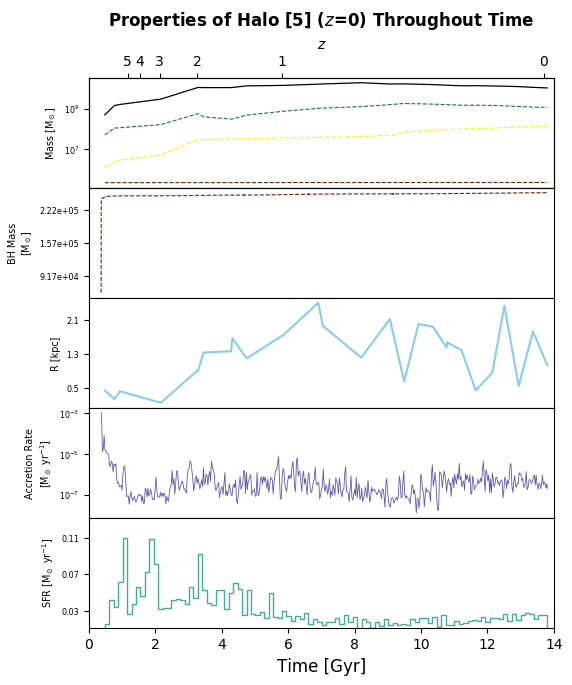

In [719]:
plot_all(i_101863883_data, adj_i101863883_orbit, time, save=False)